# 1EG 

In [384]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [467]:
df = pd.read_csv('../data/1EG.csv')

In [468]:
df.head(15)

,ID_STANA,POVRSINA,BR_OSOBA,MJESEC_sin,MJESEC_cos,MJESEC,GODINA,S_SNAGA,ENESGR
0,22419412,NaN,NaN,-0.866025,0.5,10,2010,0.019850,3.494
1,22419413,NaN,NaN,-0.866025,0.5,10,2010,0.009742,1.153
2,22419415,NaN,NaN,-0.866025,0.5,10,2010,0.044751,5.955
3,22419420,NaN,NaN,-0.866025,0.5,10,2010,0.007539,1.829
4,22419422,NaN,NaN,-0.866025,0.5,10,2010,0.053865,4.536
5,22419424,NaN,NaN,-0.866025,0.5,10,2010,0.008190,1.986
6,22419425,NaN,NaN,-0.866025,0.5,10,2010,0.012804,1.705
7,22419426,NaN,NaN,-0.866025,0.5,10,2010,0.007188,0.958
8,22419427,NaN,NaN,-0.866025,0.5,10,2010,0.005454,0.646
9,22419429,NaN,NaN,-0.866025,0.5,10,2010,0.004194,0.522


In [469]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 661191 entries, 0 to 661190
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ID_STANA    661191 non-null  int64  
 1   POVRSINA    268818 non-null  float64
 2   BR_OSOBA    25190 non-null   float64
 3   MJESEC_sin  661191 non-null  float64
 4   MJESEC_cos  661191 non-null  float64
 5   MJESEC      661191 non-null  int64  
 6   GODINA      661191 non-null  int64  
 7   S_SNAGA     661069 non-null  float64
 8   ENESGR      521802 non-null  float64
dtypes: float64(6), int64(3)
memory usage: 45.4 MB


## Preprocesiranje

Dodajemo godisnje doba u skup.

In [470]:
def add_seasons(df):
    """
    Metoda za dodavanje sezone u skup.
    """
    # Definiramo mapiranje mjeseci u godisnja doba
    season_map = {
        12: 'Zima', 1: 'Zima', 2: 'Zima',
        3: 'Proljece', 4: 'Proljece', 5: 'Proljece',
        6: 'Ljeto', 7: 'Ljeto', 8: 'Ljeto',
        9: 'Jesen', 10: 'Jesen', 11: 'Jesen'
    }
    
    df['SEZONA'] = df['MJESEC'].map(season_map)
    df['SEZONA'] = df['SEZONA'].astype('category')
    return df

In [471]:
df = add_seasons(df)
df = df.drop(columns=['MJESEC_sin', 'MJESEC_cos'])

Posto je ovo kategoricka varijabla dodati cemo jos ordinalno kodiranje kako bi mogli promatrati korelacije.

In [472]:
def encode_seasons_ordinal(df):
    """
    Metoda za ordinalno kodiranje kategoricke varijable SEZONA.
    """
    
    # Definiramo mapiranje
    ordinal_map = {
        'Zima': 1.0,
        'Jesen': 0.66,
        'Proljeće': 0.33,
        'Ljeto': 0.0
    }
    df['SEZONA_NUM'] = df['SEZONA'].map(ordinal_map)
    return df

In [473]:
df = encode_seasons_ordinal(df)

Ako je ENESGR jednako nula ili null to izbacujemo iz skupa. Takoder odvajamo skup na poslovne i privatne subjekte.

In [474]:
df = df[df['ENESGR'].notna() & (df['ENESGR'] != 0)]
df_F = df[df['ID_STANA']<40_000_000]
df = df[df['ID_STANA']>40_000_000]

In [475]:
df.info()

<class 'pandas.DataFrame'>
Index: 89799 entries, 64707 to 661179
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ID_STANA    89799 non-null  int64   
 1   POVRSINA    89799 non-null  float64 
 2   BR_OSOBA    22904 non-null  float64 
 3   MJESEC      89799 non-null  int64   
 4   GODINA      89799 non-null  int64   
 5   S_SNAGA     89799 non-null  float64 
 6   ENESGR      89799 non-null  float64 
 7   SEZONA      89799 non-null  category
 8   SEZONA_NUM  66394 non-null  float64 
dtypes: category(1), float64(5), int64(3)
memory usage: 6.3 MB


In [476]:
df_F.info()

<class 'pandas.DataFrame'>
Index: 381057 entries, 0 to 661181
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   ID_STANA    381057 non-null  int64   
 1   POVRSINA    103900 non-null  float64 
 2   BR_OSOBA    191 non-null     float64 
 3   MJESEC      381057 non-null  int64   
 4   GODINA      381057 non-null  int64   
 5   S_SNAGA     381057 non-null  float64 
 6   ENESGR      381057 non-null  float64 
 7   SEZONA      381057 non-null  category
 8   SEZONA_NUM  259284 non-null  float64 
dtypes: category(1), float64(5), int64(3)
memory usage: 26.5 MB


In [477]:
# Sto ako izbacimo sve retke koji za povrsinu imaju 0 ili null? 
# (Od)komentiraj ovaj blok.
df = df[df['POVRSINA'].notna() & (df['POVRSINA'] != 0)]

In [478]:
df.head()

,ID_STANA,POVRSINA,BR_OSOBA,MJESEC,GODINA,S_SNAGA,ENESGR,SEZONA,SEZONA_NUM
64707,424100150014,140.0,NaN,1,2012,0.019411,3.460,Zima,1.0
64708,424100160010,110.0,NaN,1,2012,0.011281,3.859,Zima,1.0
64709,424100230018,200.0,NaN,1,2012,0.012551,0.526,Zima,1.0
64710,424100200011,120.0,NaN,1,2012,0.028067,5.267,Zima,1.0
64711,424100210017,300.0,NaN,1,2012,0.028397,3.909,Zima,1.0


In [479]:
df.info()

<class 'pandas.DataFrame'>
Index: 89799 entries, 64707 to 661179
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ID_STANA    89799 non-null  int64   
 1   POVRSINA    89799 non-null  float64 
 2   BR_OSOBA    22904 non-null  float64 
 3   MJESEC      89799 non-null  int64   
 4   GODINA      89799 non-null  int64   
 5   S_SNAGA     89799 non-null  float64 
 6   ENESGR      89799 non-null  float64 
 7   SEZONA      89799 non-null  category
 8   SEZONA_NUM  66394 non-null  float64 
dtypes: category(1), float64(5), int64(3)
memory usage: 6.3 MB


In [573]:
target = "ENESGR"

## Grafovi

### Provjera korelacija

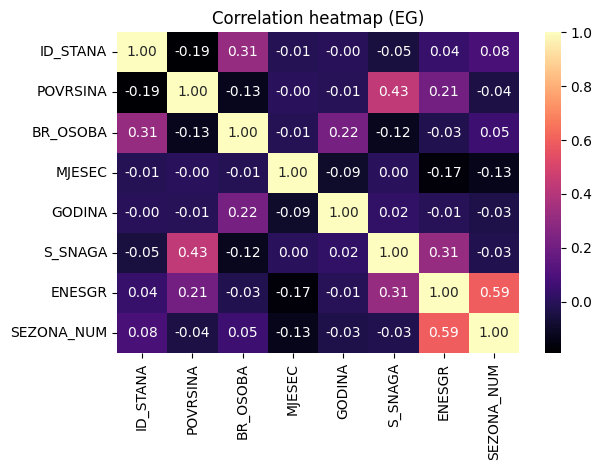

In [480]:
corr = df.corr(numeric_only=True)

#df_with_dummies = pd.get_dummies(df, columns=['SEZONA'], prefix='S')
#corr = df_with_dummies.corr(numeric_only=True)

ax = sns.heatmap(corr, cmap="magma", annot=True, fmt=".2f")
ax.set_title("Correlation heatmap (EG)")

plt.tight_layout()
plt.show()

Vidimo da zapravo korelacija izmedu mjeseca i potrosnje nije toliko bitna, ali je snaga na jedinici preko koje se direktno i racuna potrosnja. Takoder vidimo da broj osoba nema utjecaja, ali povrsina je jako korelirana i to cemo koristiti u nastavku.
<br>
**Ovo nije vise tocno jer promatramo drugaciji skup (nema vise poslovnih subjekata)** 
Sada zapravo uocavamo da je najveca korelacija upravo sa sezonom, te SUC snagom.

## Trendovi podataka

In [399]:
def diagnose_features(data, features, target):
    """
    Metoda za graficki pregled trendova u podatcima.
    """
    num_features = len(features)
    rows = (num_features + 1) // 2
    fig, axes = plt.subplots(rows, 2, figsize=(15, 5 * rows))
    axes = axes.flatten()

    for i, col in enumerate(features):
        # Crtamo podatke i trend
        sns.regplot(
            data=data, 
            x=col, 
            y=target, 
            ax=axes[i],
            scatter_kws={'alpha': 0.2, 's': 10}, 
            line_kws={'color': 'red'},
            lowess=True # Lowess crta liniju koja prati lokalni trend (otkriva zakrivljenost)
        )
        axes[i].set_title(f'{target} vs {col}')
        axes[i].grid(True, linestyle='--', alpha=0.6)

    # Brišemo prazne grafove ako ih ima
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

/Users/dzanijaivan/Developer/AnomalyDetection/.venv/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


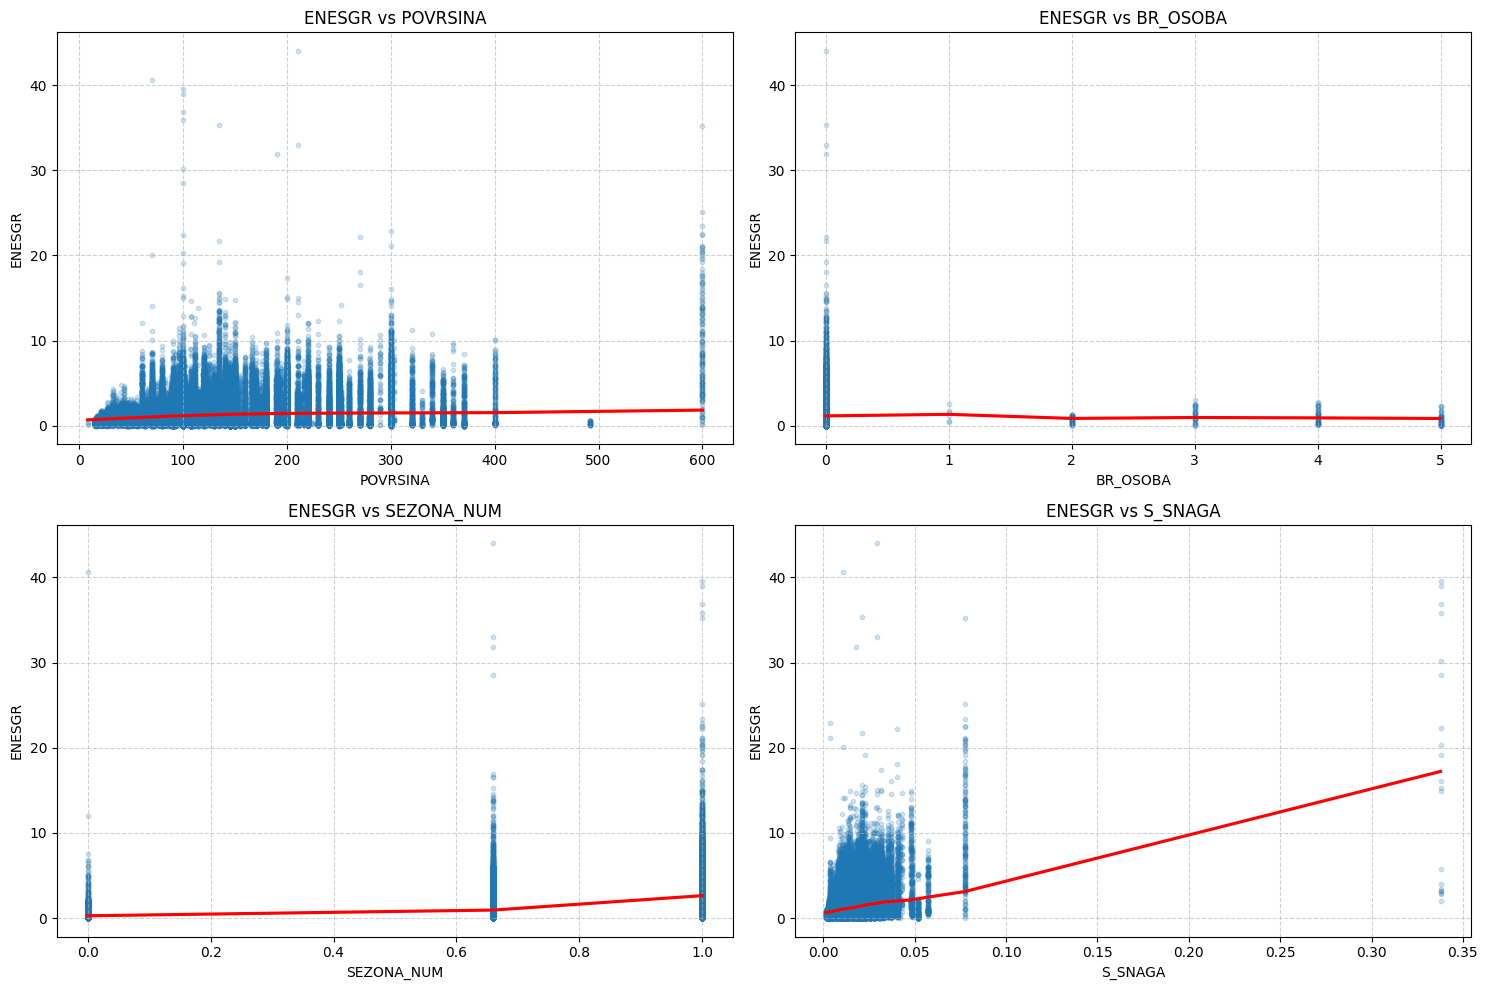

In [400]:
diagnose_features(df, ['POVRSINA', 'BR_OSOBA', 'SEZONA_NUM', 'S_SNAGA'], 'ENESGR')

Ovime smo se uvjerili da broj osoba ima zanemariv ucinak na ukupnu potrosnju energije neke jedinice.

## Grupiranje 

### K-sredina

In [582]:
from sklearn.metrics import silhouette_score

def find_optimal_k(data, features, title, target=None):
    """
    Metoda za trazenje optimaknog broja grupa k nad podatcima i znacajkama
    """
    features = features.copy()
    if target is not None:
        features.append(target)
    
    X_sub = data[features].dropna()
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_sub)
    
    inertia = []
    silhouette_avg = []
    K_range = range(2, 9)

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        inertia.append(kmeans.inertia_)
        
        # Silhouette na uzorku zbog brzine ako je dataset velik
        # Ovo mozda maknuti -> presporo
        sample_size = min(len(X_scaled), 5000)
        # sample_size = len(X_scaled)
        idx = np.random.choice(len(X_scaled), sample_size, replace=False)
        current_silhouette = silhouette_score(X_scaled[idx], labels[idx])
        silhouette_avg.append(current_silhouette)
        print(f"{k:<5} | {current_silhouette:<15.4f}")

    # Plotting
    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.set_xlabel('Broj klastera (k)')
    ax1.set_ylabel('Inertia (Lakat)', color='blue')
    ax1.plot(K_range, inertia, 'bo-')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Silhouette Score (Više je bolje)', color='red')
    ax2.plot(K_range, silhouette_avg, 'ro-')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.title(f'Određivanje optimalnog k za: {title}')
    plt.show()

2     | 0.3995         
3     | 0.4378         
4     | 0.4483         
5     | 0.3750         
6     | 0.3456         
7     | 0.3611         
8     | 0.3633         


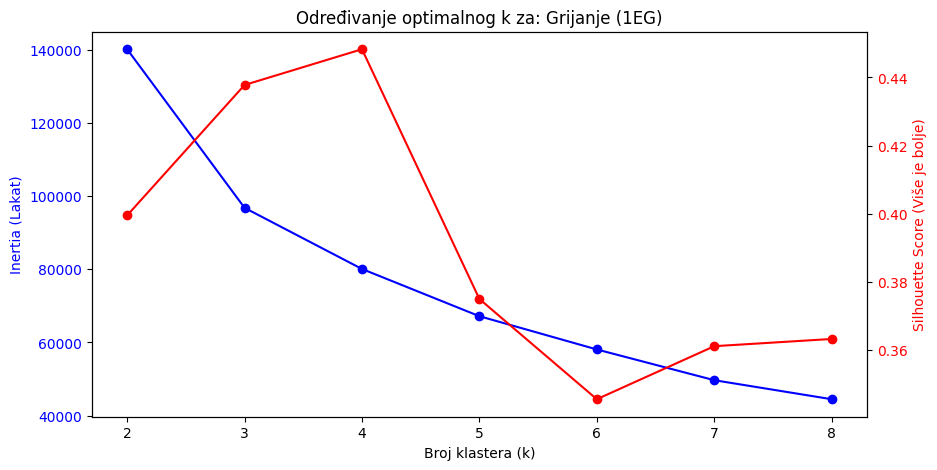

In [569]:
# Procjena optimalnog broja grupa
_features = ["POVRSINA", "S_SNAGA", "SEZONA_NUM"]
find_optimal_k(df, _features, "Grijanje (1EG)")

Najbolji odabir broja grupa je 3 ili 4 iz ovoga. Nastavljamo sa 3 grupe.

In [581]:
def perform_clustering(data, features, n_clusters=4, target=None):
    """ 
    Metoda za grupiranje podataka.
    """
    features = features.copy()
    if target is not None:
        features.append(target)
    df_sub = data[features].dropna().copy()
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_sub)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df_sub['cluster'] = kmeans.fit_predict(scaled_data)
    
    return df_sub['cluster']

In [566]:
df['cluster'] = perform_clustering(df, _features, 3)
print(f"Klasteri:\n{df['cluster'].value_counts()}")

Klasteri:
cluster
0    57127
2    16626
1    16046
Name: count, dtype: int64


### Metode za 2d/3d prikaz grupa

In [587]:
def plot_clustering_2d(df, features, target=None):
    """
    Metoda za graficki prikaz grupa.
    """
    features = features.copy()
    if target is not None:
        features.append(target)
        
    if 'cluster' not in df.columns:
        print("Klasteri nisu pronađeni u DataFrame-u. Molimo pokrenite perform_clustering prvo.")

    # Izracun centroida 
    centroids = df.groupby('cluster')[features].mean().reset_index()
    
    plt.figure(figsize=(10, 7))
    
    sns.scatterplot(
        data=df, 
        x=features[0],
        y=features[1],
        hue='cluster', 
        palette='viridis', 
        s=50,             
        alpha=0.6,        
        edgecolor='w',    
        legend='full'     
    )
    
    # Crtanje centroida 
    sns.scatterplot(
        data=centroids, 
        x=features[0],
        y=features[1],
        marker='X',        
        s=250,             
        color='red',       
        edgecolor='black', 
        label='Centroidi'  
    )
    
    plt.title('Klasteri i Centroidi')
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.show()

In [588]:
from mpl_toolkits.mplot3d import Axes3D

def plot_clustering_3d(df, features, target=None):
    """
    Metoda za 3D graficki prikaz grupa
    """
    features = features.copy()
    if target is not None:
        features.append(target)
    if len(features) < 3:
        print("Za 3D prikaz su potrebne točno 3 znacajke u listi 'features'.")
        return

    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')

    # Izračun centroida za 3 značajke
    centroids = df.groupby('cluster')[features].mean().reset_index()

    # Boje za klastere (korištenje viridis palete)
    scatter = ax.scatter(
        df[features[0]], 
        df[features[1]], 
        df[features[2]], 
        c=df['cluster'], 
        cmap='viridis', 
        s=40, 
        alpha=0.5, 
        edgecolor='w'
    )

    # Crtanje centroida
    ax.scatter(
        centroids[features[0]], 
        centroids[features[1]], 
        centroids[features[2]], 
        marker='X', 
        s=300, 
        color='red', 
        edgecolor='black', 
        label='Centroidi'
    )

    # Postavljanje labela
    ax.set_xlabel(features[0])
    ax.set_ylabel(features[1])
    ax.set_zlabel(features[2])
    ax.set_title('3D Prikaz Klastera i Centroida')

    # Dodavanje legende za klastere
    legend1 = ax.legend(*scatter.legend_elements(), title="Klasteri", loc="upper left")
    ax.add_artist(legend1)
    ax.legend(loc="upper right")

    plt.show()

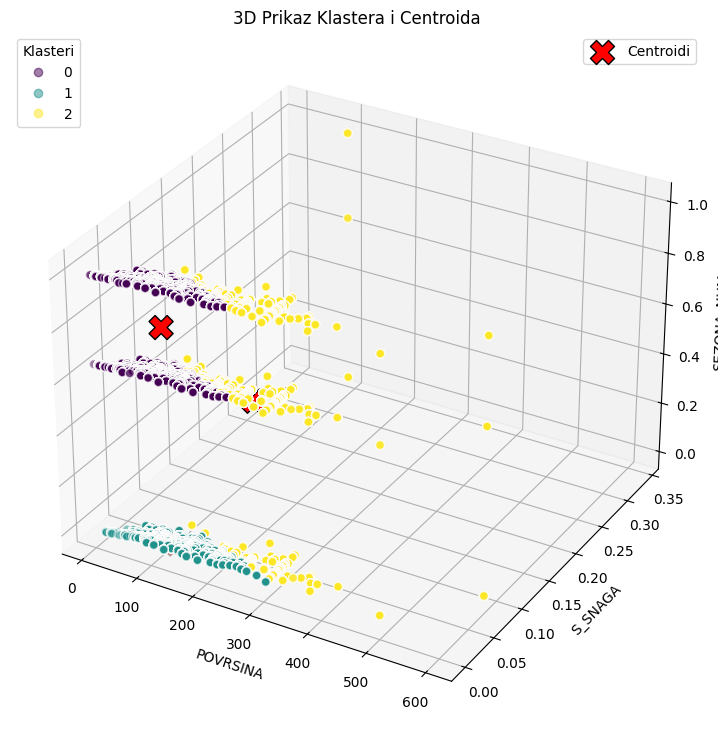

In [444]:
# plot_clustering_2d(df, _features)
# plot_clustering_3d(df, _features + ["ENESGR"])
plot_clustering_3d(df, _features)

Ovdje vidimo problem da puno stanova ima vrijednost povrsine 0 (vjerojatno nije nikad mjerena jer ne ulazi u izracun).
<br>
**Takoder vise ne vrijedi :)**
Vidimo da zapravo ovakvo grupiranje ima smisla

In [445]:
def analyze_clusters(data, features, target=None):
    """
    Racuna prosjek i standardnu devijaciju za zadane znacajke po klasterima.
    """
    cols_to_analyze = features.copy()
    if target:
        cols_to_analyze.append(target)
    
    # Grupiranje po klasteru i racunanje agregacija
    analysis = data.groupby('cluster')[cols_to_analyze].agg(['mean', 'std'])
    
    analysis.columns = [f"{col}_{stat}" for col, stat in analysis.columns]
    
    print("--- Analiza klastera (Prosjek i Std Dev) ---")
    return analysis

In [447]:
cluster_stats = analyze_clusters(df, _features, target='ENESGR')
display(cluster_stats)

--- Analiza klastera (Prosjek i Std Dev) ---


,POVRSINA_mean,POVRSINA_std,S_SNAGA_mean,S_SNAGA_std,SEZONA_NUM_mean,SEZONA_NUM_std,ENESGR_mean,ENESGR_std
cluster,,,,,,,,
0.0,113.708465,39.239956,0.015086,0.005675,0.841084,0.169641,2.074872,1.717003
1.0,127.755699,43.504216,0.015957,0.005309,0.000000,0.000000,0.257225,0.396030
2.0,259.355524,65.002794,0.025997,0.014978,0.632790,0.381993,2.566051,2.702895


Vidimo da od ovog pristupa nismo dobili nista konkretno.

## Linearni modeli

In [448]:
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression

def detect_outliers_regression(data, features, target):
    """
    Metoda za odredivanje outliera na temelju linearne regresije.
    """
    df_reg = data.copy().dropna(subset=features + [target])
    
    # 1. Treniranje modela
    X = df_reg[features]
    y = df_reg[target]
    
    model = LinearRegression()
    model.fit(X, y)
    
    # 2. Predvidanje
    df_reg['prediction'] = model.predict(X)
    df_reg['residual'] = df_reg[target] - df_reg['prediction']
    
    # 3. Izracun standardne devijacije reziduala (sigma)
    sigma = np.std(df_reg['residual'])
    
    # Racunamo Z-score za detekciju
    df_reg['z_score'] = zscore(df_reg['residual'])
    
    # Definiramo outliere (izvan +/- 3 sigme)
    outliers = df_reg[df_reg['z_score'] > 3] 
    normals = df_reg[df_reg['z_score'] <= 3]
    
    print(f"Pronadeno {len(outliers)} ekstrema od {len(df_reg)} zapisa (Sigma={sigma:.2f}).")
    
    plt.figure(figsize=(12, 8))
    plt.scatter(normals['prediction'], normals[target], 
                c='blue', alpha=0.3, s=20, label='Normalna potrosnja')
    plt.scatter(outliers['prediction'], outliers[target], 
                c='red', alpha=0.9, s=50, edgecolors='black', label='Outlieri (>3σ)')
    line_x = np.linspace(df_reg['prediction'].min(), df_reg['prediction'].max(), 100)
    plt.plot(line_x, line_x, color='black', linestyle='--', linewidth=2, label='Idealno predvidanje')
    plt.fill_between(line_x, 
                     line_x - 3*sigma, 
                     line_x + 3*sigma, 
                     color='green', alpha=0.15, label='Zona tolerancije (±3σ)')
    
    plt.xlabel(f'Ocekivana potrošnja - Model ({target})')
    plt.ylabel(f'Stvarna potrošnja ({target})')
    plt.title(f'Detekcija Outliera: Stvarno vs. Očekivano\n(Varijable: {", ".join(features)})')
    plt.legend(loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.5)
    
    plt.show()
    
    return outliers.sort_values(by='z_score', ascending=False)

Pronadeno 842 ekstrema od 66394 zapisa (Sigma=1.43).


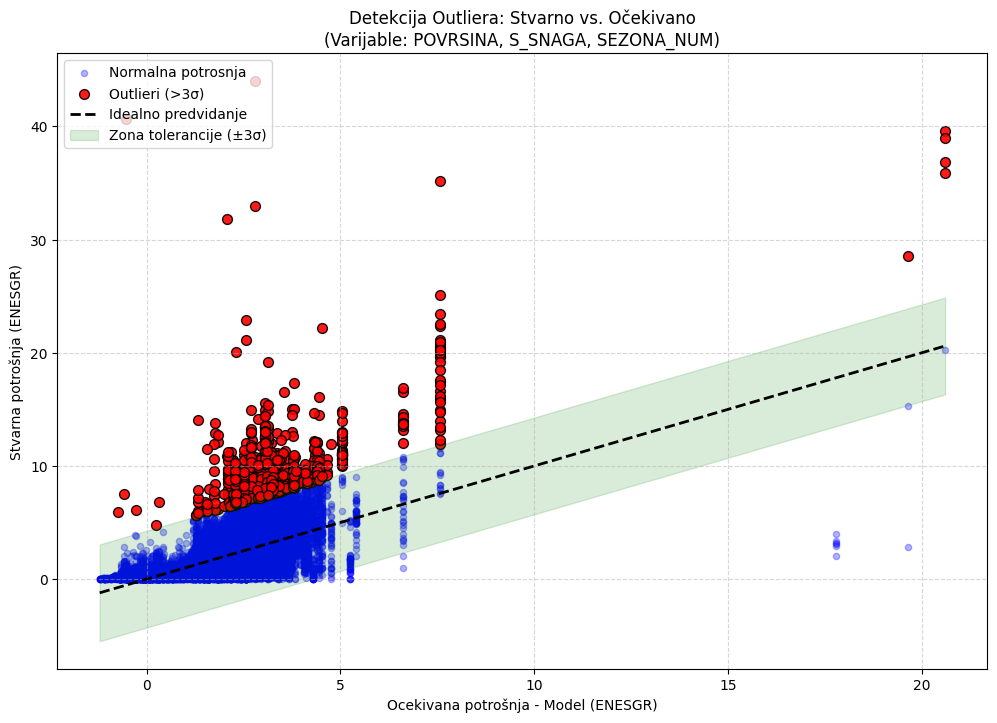

In [449]:
outliers = detect_outliers_regression(df, _features, 'ENESGR')

## Grupiranje s ciljnom varijablom 

Ovo ne koristimo vise :)

Iako se ovakav pristup inace izbjegava, ovime bi mogli stvoriti "energetske razrede".

###  K-sredina

In [412]:
# Procjena optimalnog broja grupa
# _features = ['POVRSINA', "ENESGR"]
# find_optimal_k(df, _features, "Grijanje (1EG)")

Sada cemo uzeti 4 razreda.

In [413]:
# df['cluster'] = perform_clustering(df, _features, 3)
# print(f"Klasteri:\n{df['cluster'].value_counts()}")

In [414]:
# plot_clustering_2d(df, _features)

Iako objekti ogromne povrsine ovdje izgledaju kao da su krivo grupirani, ali interpretacija ovoga bi
mogla biti da je zuta grupa zapravo skup negrijanih jedinica koje ili sluze za nekakve ostave ili zbog nekog drugog razloga nisu useljene.

In [415]:
# cluster_stats = analyze_clusters(df, _features, target='ENESGR')
# display(cluster_stats)

## Regresija po grupama

In [529]:
def perform_cluster_regression(df, features, target, trim_pct=0.025):
    """
    Metoda za regresiju po klasterima + subplot po klasteru
    trim_pct: postotak za izbacivanje ekstremnih y vrijednosti (npr. 0.01 = 1%)
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.linear_model import LinearRegression

    df_res = df.copy()
    
    df_res['prediction'] = np.nan
    df_res['residual'] = np.nan
    df_res['z_score_local'] = np.nan
    
    clusters = sorted(df_res['cluster'].unique())
    n_clusters = len(clusters)
    
    # Layout (max 3 po redu)
    n_cols = min(3, n_clusters)
    n_rows = int(np.ceil(n_clusters / n_cols))
    
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(5 * n_cols, 4 * n_rows),
        squeeze=False, sharex=False, sharey=False
    )
    
    print(f"{'Klaster':<10} | {'Prosjek':<12} | {'Lokalna Sigma':<15}")
    print("-" * 45)
    
    for idx, cl in enumerate(clusters):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        
        mask = df_res['cluster'] == cl
        subset = df_res[mask]
        
        if len(subset) < 2:
            ax.set_visible(False)
            continue
        
        X = subset[features]
        y = subset[target]

        # --- TRIM po y (1% dolje i 1% gore po default) ---
        q_low, q_high = y.quantile([trim_pct, 1 - trim_pct])
        trim_mask = (y >= q_low) & (y <= q_high)
        
        X_trim = X[trim_mask]
        y_trim = y[trim_mask]
        
        if len(y_trim) < 2:
            ax.set_visible(False)
            continue
        
        # Treniranje regresije na trimmed podacima
        model = LinearRegression()
        model.fit(X_trim, y_trim)
        
        preds = model.predict(X_trim)
        resids = y_trim - preds
        local_sigma = np.std(resids)
        
        # --- Ispravan upis u df_res (samo za trimmed podatke) ---
        final_mask = mask & trim_mask.reindex(df_res.index, fill_value=False)
        df_res.loc[final_mask, 'prediction'] = preds
        df_res.loc[final_mask, 'residual'] = resids
        df_res.loc[final_mask, 'z_score_local'] = (
            resids / local_sigma if local_sigma > 0 else 0
        )
        
        print(f"{cl:<10} | {y_trim.mean():<12.2f} | {local_sigma:<15.2f}")
        
        # --- PLOT PO KLASTERU ---
        ax.scatter(
            preds, y_trim,
            alpha=0.6,
            s=30
        )
        
        # Idealna linija y = x
        x_min = min(preds.min(), y_trim.min())
        x_max = max(preds.max(), y_trim.max())
        x_line = np.linspace(x_min, x_max, 100)
        
        ax.plot(
            x_line, x_line,
            linestyle='--',
            linewidth=2
        )
        
        # ±3σ zona
        if local_sigma > 0:
            ax.fill_between(
                x_line,
                x_line - 3 * local_sigma,
                x_line + 3 * local_sigma,
                alpha=0.15
            )
        
        # Prisilno autoscale samo za ovaj ax
        ax.relim()
        ax.autoscale_view()
        
        ax.set_title(f'Klaster {cl}')
        ax.set_xlabel('Predikcija')
        ax.set_ylabel('Stvarno')
        ax.grid(True, linestyle='--', alpha=0.4)
    
    # Sakrij prazne subplotove
    for i in range(n_clusters, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Označavanje outliera po lokalnom z-scoreu
    df_res['is_outlier'] = df_res['z_score_local'].abs() > 3
    
    return df_res


Klaster    | Prosjek (kWh)   | Lokalna Sigma  
---------------------------------------------
0.0        | 2.07            | 1.40           
2.0        | 2.57            | 1.99           
1.0        | 0.26            | 0.39           


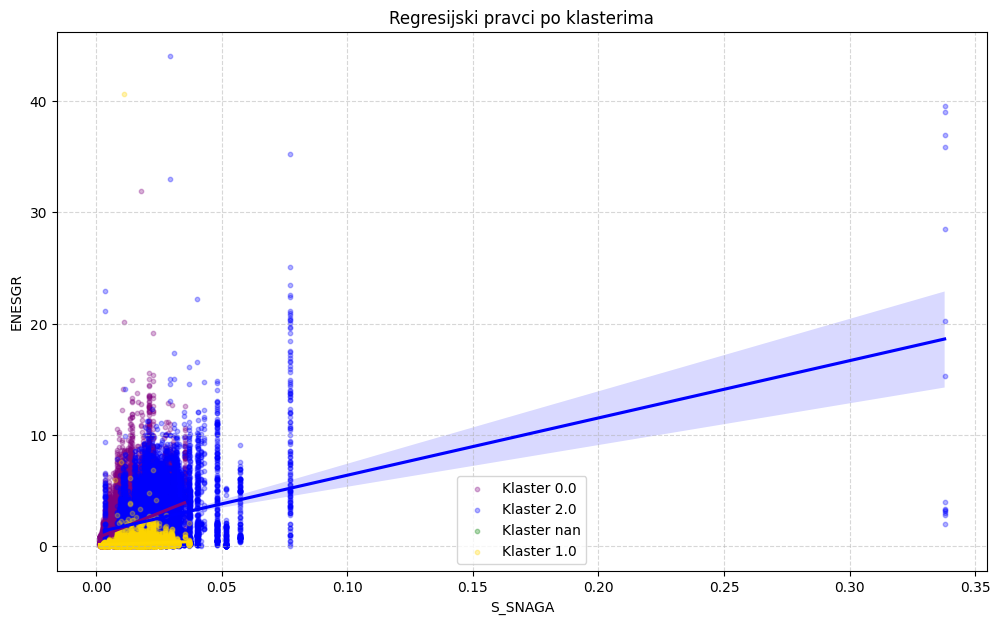

In [452]:
df_final = perform_cluster_regression(df, _features, 'ENESGR')

WOW :) 

In [ ]:
import statsmodels.formula.api as smf

def quantile_detection_by_cluster(df, q_level=0.95):
    df_res = df.copy()
    df_res['quant_limit'] = np.nan
    df_res['is_quant_outlier'] = False
    
    clusters = sorted(df_res['cluster'].unique())
    
    for cl in clusters:
        mask = df_res['cluster'] == cl
        subset = df_res[mask]
        
        if len(subset) < 10:
            continue
            
        # Modeliranje po klasteru
        try:
            model = smf.quantreg('ENESGR ~ POVRSINA', subset).fit(q=q_level)
            
            df_res.loc[mask, 'quant_limit'] = model.predict(subset)
            df_res.loc[mask, 'is_quant_outlier'] = df_res.loc[mask, 'ENESGR'] > df_res.loc[mask, 'quant_limit']
        except:
            print(f"Problem s izracunom za klaster {cl}")
            
    return df_res

In [ ]:
df_final = quantile_detection_by_cluster(df_final, q_level=0.95)

Ovo nam ne donosi nista novo.

## Odvajanje na 4 skupa za svako godisnje doba

https://en.wiktionary.org/wiki/throw_enough_mud_at_the_wall_and_some_of_it_will_stick
<br> Let's hope 

In [487]:
df_WIN = df[df['SEZONA']=="Zima"]
df_SUM = df[df['SEZONA']=="Ljeto"]
df_REM = df[(df['SEZONA'] == "Proljece") | (df['SEZONA'] == "Jesen")]

In [489]:
df_WIN.info()
df_SUM.info()
df_REM.info()

<class 'pandas.DataFrame'>
Index: 23894 entries, 64707 to 642521
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ID_STANA    23894 non-null  int64   
 1   POVRSINA    23894 non-null  float64 
 2   BR_OSOBA    6143 non-null   float64 
 3   MJESEC      23894 non-null  int64   
 4   GODINA      23894 non-null  int64   
 5   S_SNAGA     23894 non-null  float64 
 6   ENESGR      23894 non-null  float64 
 7   SEZONA      23894 non-null  category
 8   SEZONA_NUM  23894 non-null  float64 
dtypes: category(1), float64(5), int64(3)
memory usage: 1.7 MB
<class 'pandas.DataFrame'>
Index: 20906 entries, 87496 to 661139
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ID_STANA    20906 non-null  int64   
 1   POVRSINA    20906 non-null  float64 
 2   BR_OSOBA    5258 non-null   float64 
 3   MJESEC      20906 non-null  int64   
 4   GODINA      20906 non-nu

### ZIMA

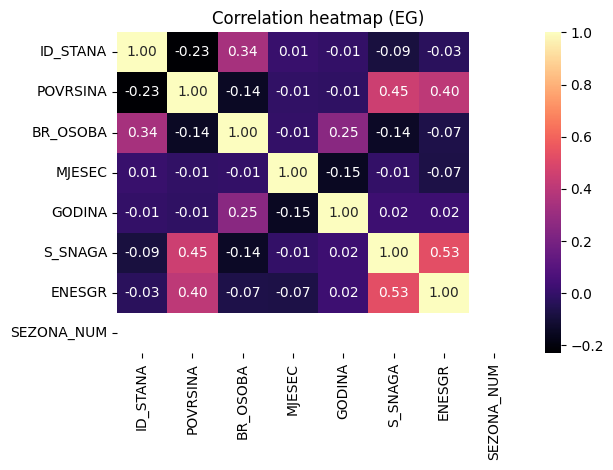

In [495]:
corr = df_WIN.corr(numeric_only=True)
ax = sns.heatmap(corr, cmap="magma", annot=True, fmt=".2f")
ax.set_title("Correlation heatmap (EG)")
plt.tight_layout()
plt.show()

/Users/dzanijaivan/Developer/AnomalyDetection/.venv/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


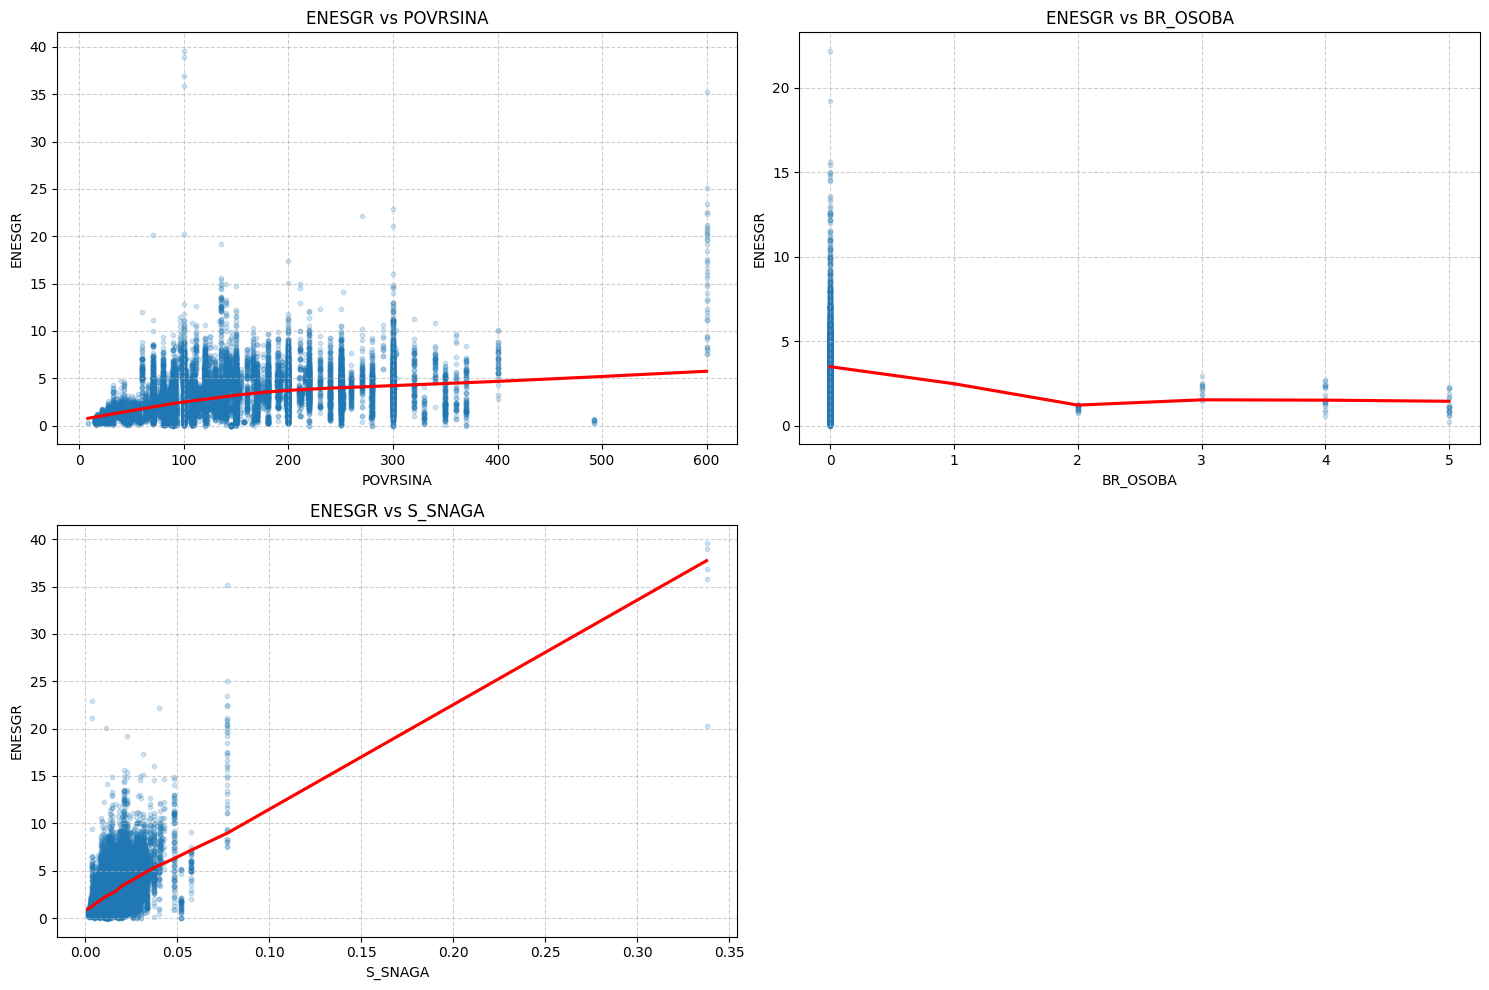

In [500]:
diagnose_features(df_WIN, ['POVRSINA', 'BR_OSOBA', 'S_SNAGA'], 'ENESGR')

2     | 0.4836         
3     | 0.4722         
4     | 0.4090         
5     | 0.3407         
6     | 0.3409         
7     | 0.3421         
8     | 0.3599         


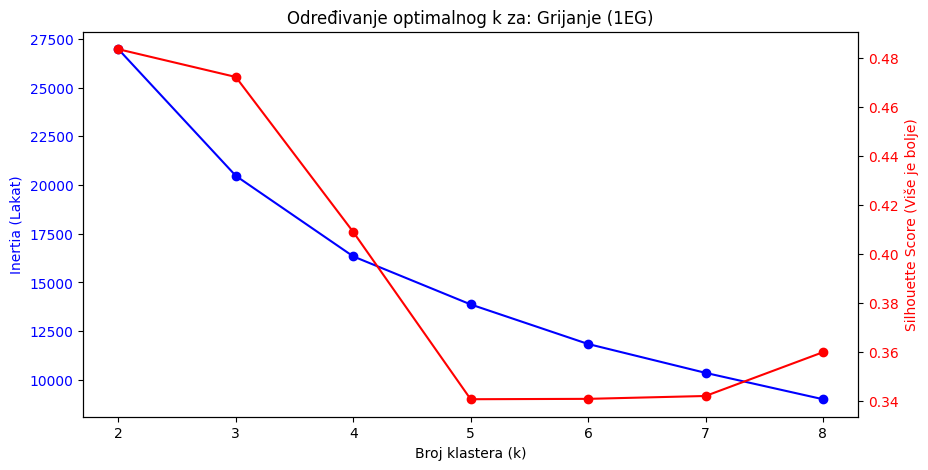

In [583]:
_features = ['POVRSINA']
find_optimal_k(df_WIN, _features, "Grijanje (1EG)", target)

Ovdje su ocite 3 grupe.

In [584]:
df_WIN['cluster'] = perform_clustering(df_WIN, _features, 3)
print(f"Klasteri:\n{df_WIN['cluster'].value_counts()}")

Klasteri:
cluster
0    12925
2     8009
1     2960
Name: count, dtype: int64


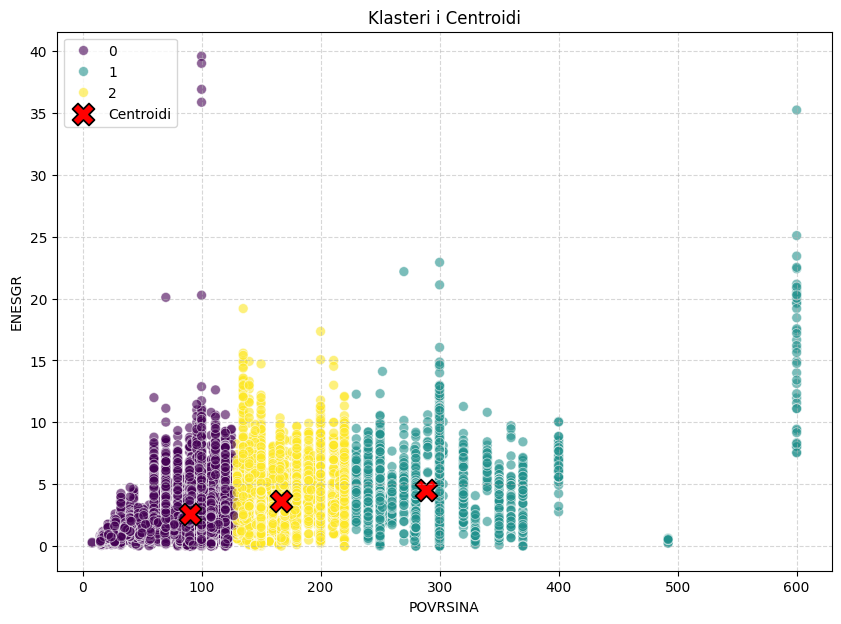

In [590]:
# plot_clustering_2d(df_WIN, _features)
plot_clustering_2d(df_WIN, _features, target)
# plot_clustering_3d(df_WIN, _features + ["ENESGR"])

Pronadeno 256 ekstrema od 23894 zapisa (Sigma=1.91).


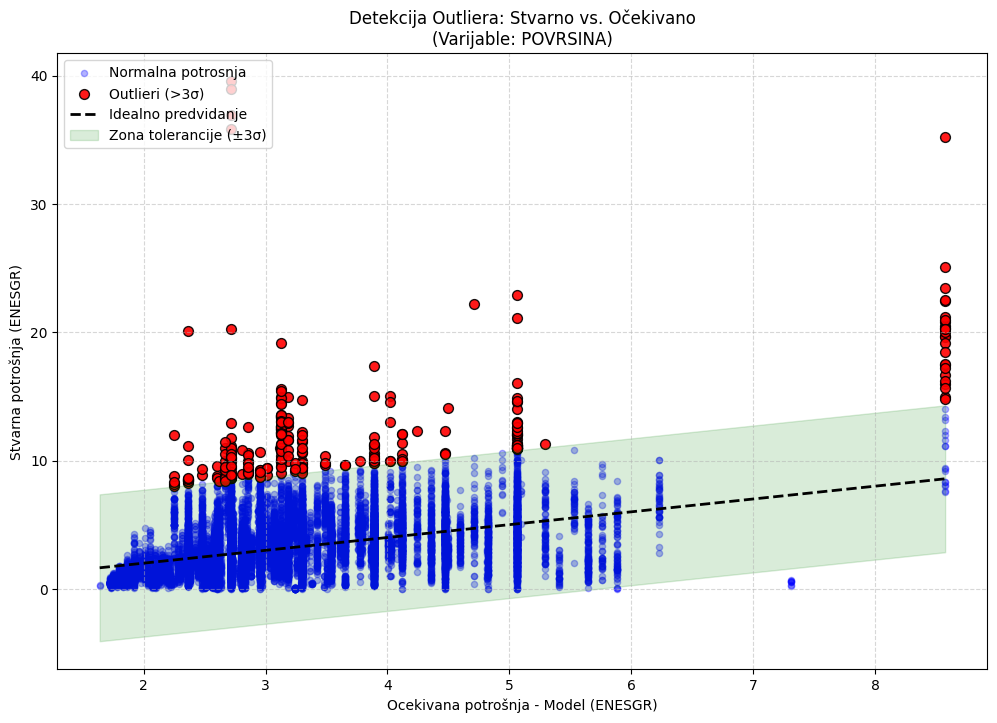

In [591]:
outliers = detect_outliers_regression(df_WIN, _features, 'ENESGR')

LOWKEY nelose?

Klaster    | Prosjek      | Lokalna Sigma  
---------------------------------------------
0          | 2.53         | 1.36           
1          | 4.42         | 2.25           
2          | 3.64         | 1.71           


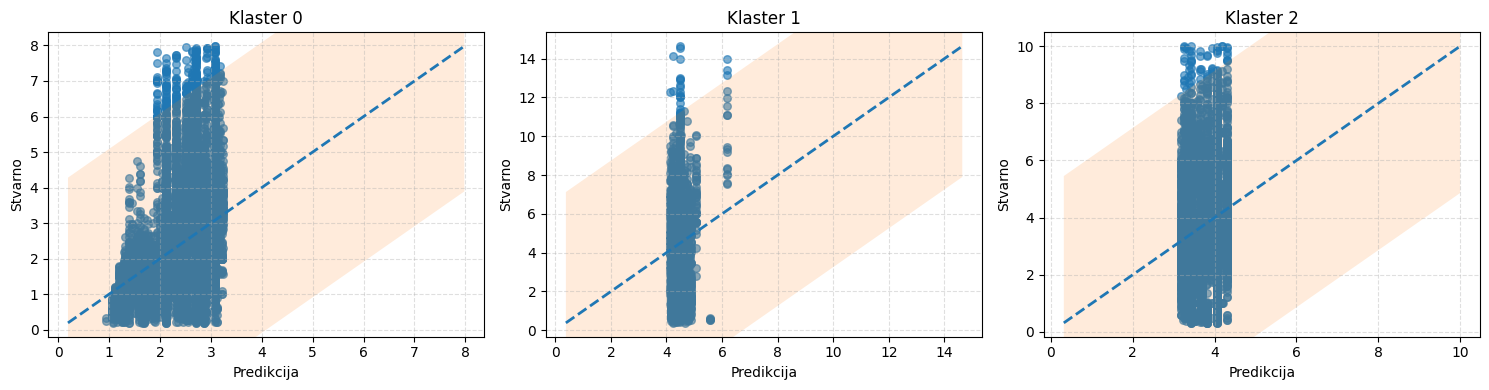

In [596]:
df_final_WIN = perform_cluster_regression(df_WIN, _features, target, 0.01)

## LJETO 

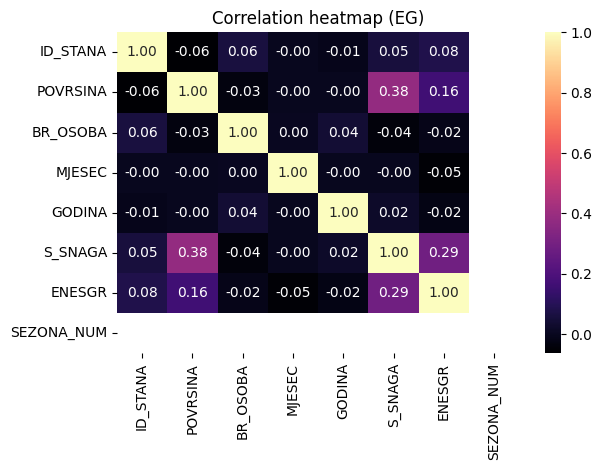

In [597]:
corr = df_SUM.corr(numeric_only=True)
ax = sns.heatmap(corr, cmap="magma", annot=True, fmt=".2f")
ax.set_title("Correlation heatmap (EG)")
plt.tight_layout()
plt.show()

Ljeti se rijetko grijanje ukljuci.

/Users/dzanijaivan/Developer/AnomalyDetection/.venv/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


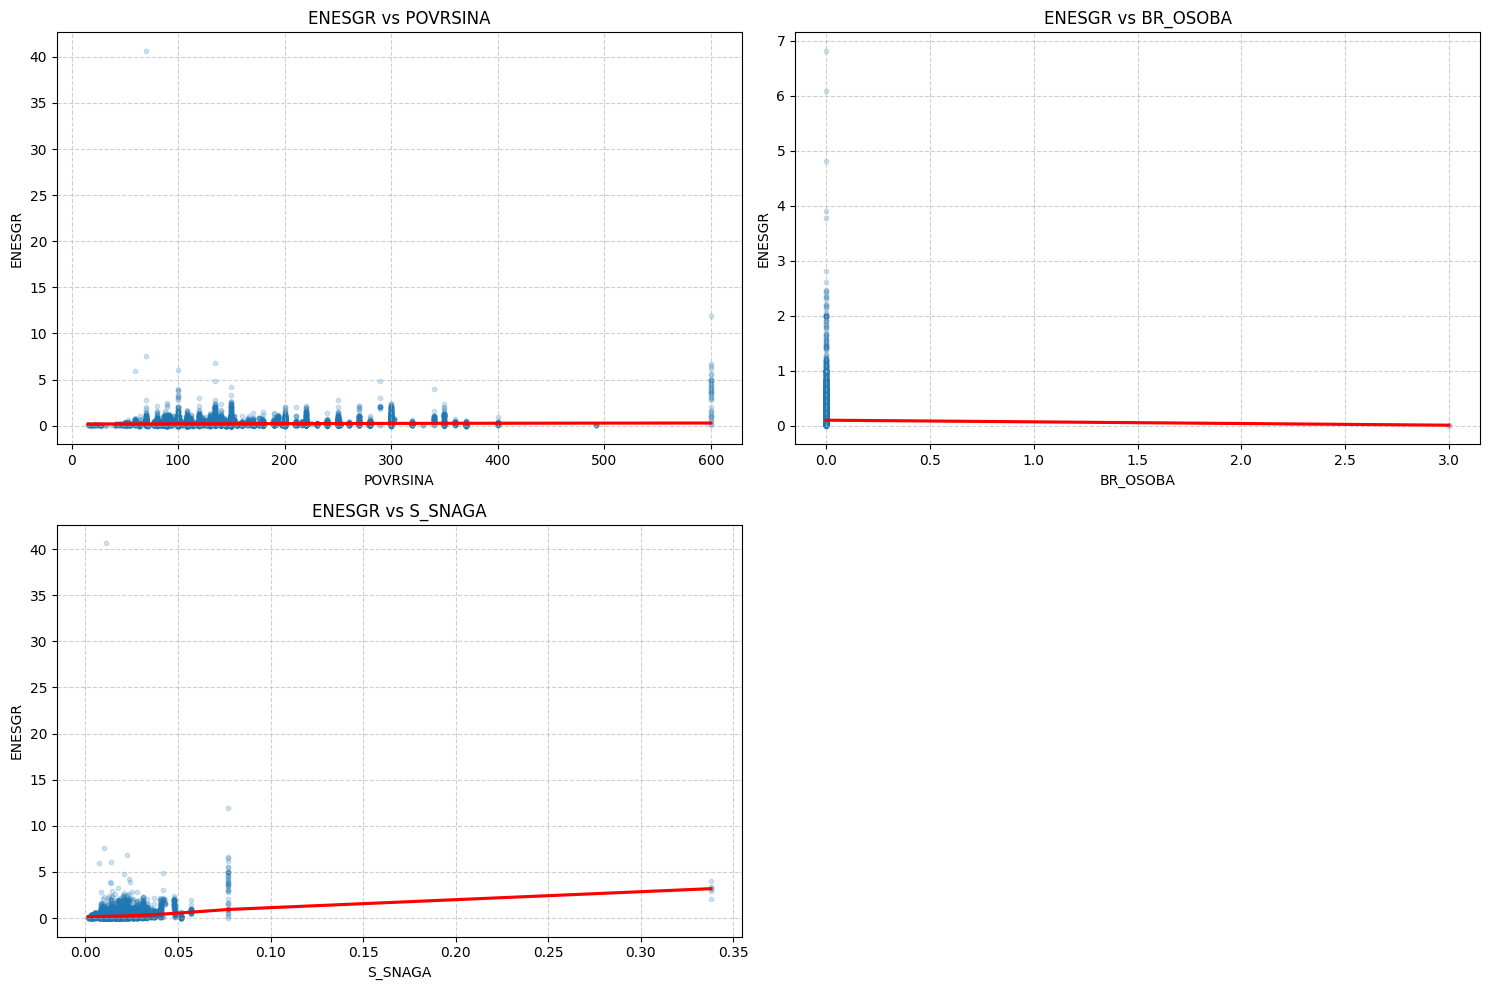

In [598]:
diagnose_features(df_SUM, ['POVRSINA', 'BR_OSOBA', 'S_SNAGA'], 'ENESGR')

Vidimo da ne postoji skoro nikav trend u podatcima.

2     | 0.5675         
3     | 0.5639         
4     | 0.5714         
5     | 0.5767         
6     | 0.4797         
7     | 0.4858         
8     | 0.4652         


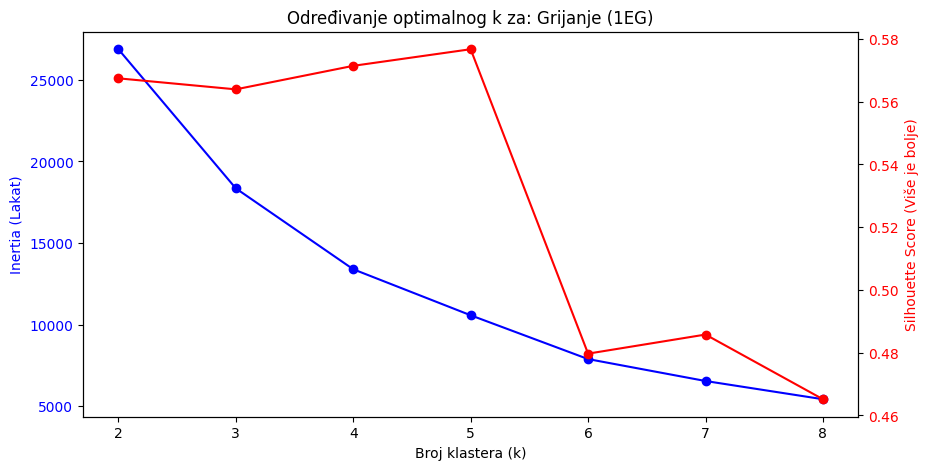

In [606]:
_features = ['POVRSINA']
find_optimal_k(df_SUM, _features, "Grijanje (1EG)", target)

In [607]:
df_SUM['cluster'] = perform_clustering(df_SUM, _features, 3)
print(f"Klasteri:\n{df_SUM['cluster'].value_counts()}")

Klasteri:
cluster
2    11012
0     7076
1     2818
Name: count, dtype: int64


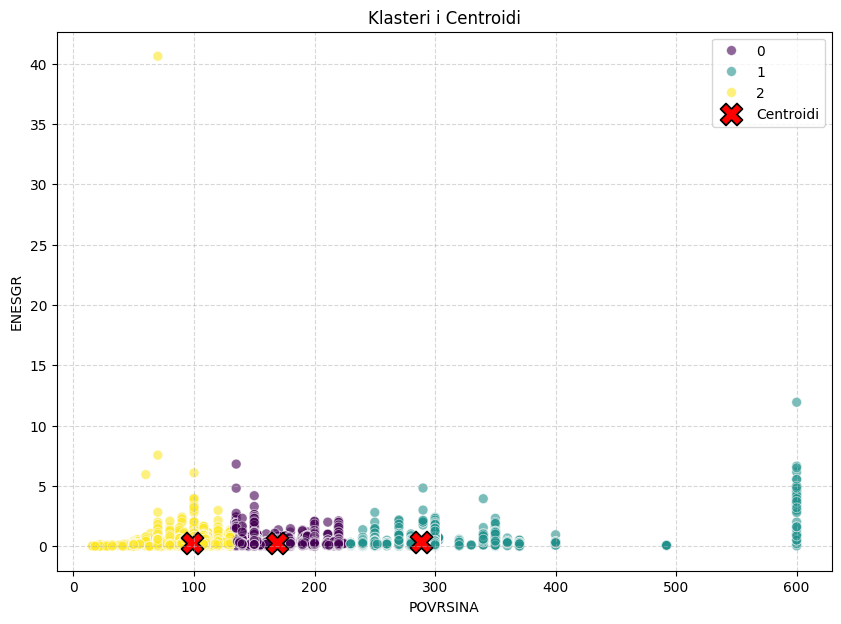

In [610]:
# plot_clustering_2d(df_WIN, _features)
plot_clustering_2d(df_SUM, _features, target)
# plot_clustering_3d(df_SUM, _features, target)

Pronadeno 180 ekstrema od 20906 zapisa (Sigma=0.43).


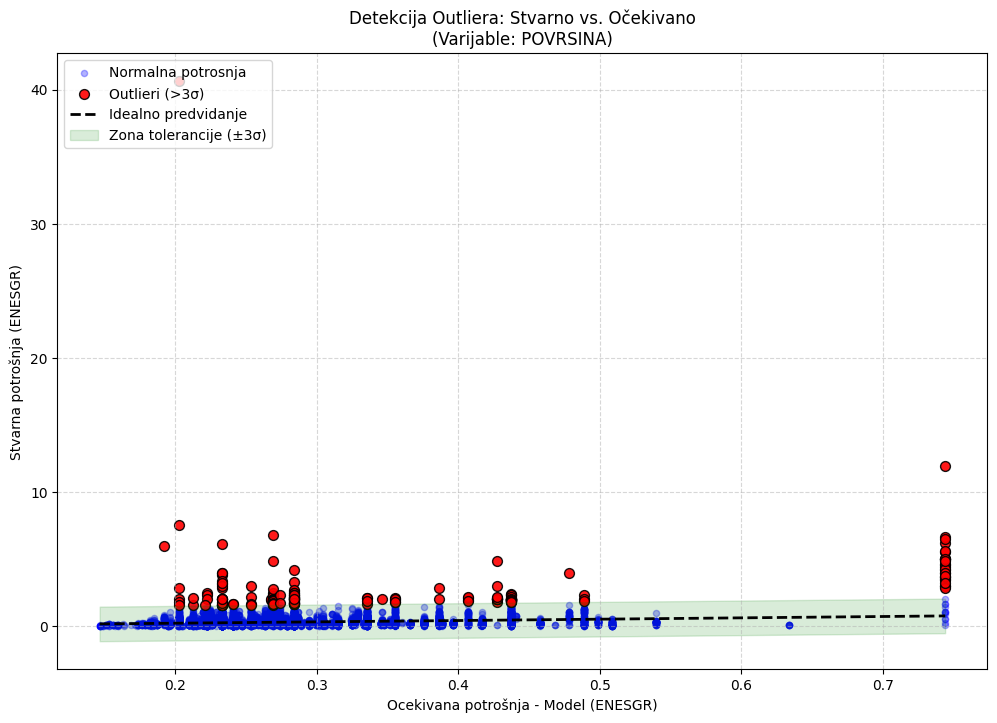

In [613]:
outliers = detect_outliers_regression(df_SUM, _features, target)

Klaster    | Prosjek      | Lokalna Sigma  
---------------------------------------------
0          | 0.27         | 0.22           
1          | 0.35         | 0.34           
2          | 0.23         | 0.18           


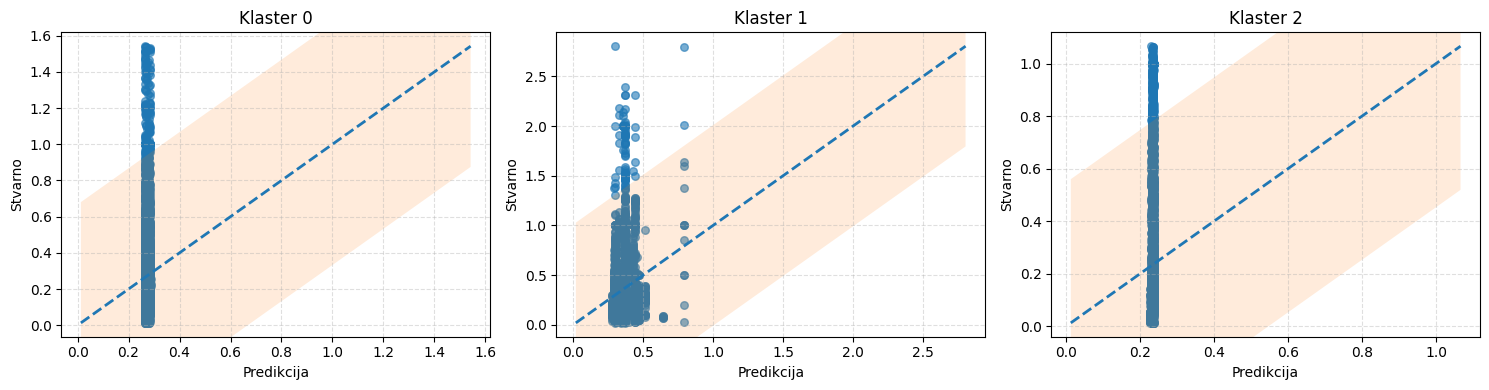

In [614]:
df_final_SUM = perform_cluster_regression(df_SUM, _features, target, 0.01)

## Time series?  

Vidimo da sa prijasnim pokusajima imamo malo uspjeha (iako zapravo ne znamo postoje li ovdje uopce outlieri). 
Idemo pokusati promatrati stan kao vremenski niz. Mozda nije zapravo problem ako stan trosi vise nego ostali stanovi slicne povrsine ako je to konzistentno.

In [ ]:
import random

def plot_random_time_series(df, n_apartments=5):
    """
    Metoda za prikaz vremenske serije potrosnje nasumicno odabranih stanova.
    """
    df_ts = df.copy()
    
    df_ts['Date'] = pd.to_datetime(
        df_ts[['GODINA', 'MJESEC']]
        .rename(columns={'GODINA': 'year', 'MJESEC': 'month'}) # PANDAS JE SHIT
        .assign(day=1)
    )
    
    # 2. Odabir 5 nasumicnih ID-ova stanova
    unique_ids = df_ts['ID_STANA'].unique()
    random_ids = random.sample(list(unique_ids), min(n_apartments, len(unique_ids)))
    
    # 3. Filtriranje i sortiranje po datumu 
    subset = df_ts[df_ts['ID_STANA'].isin(random_ids)].sort_values(['ID_STANA', 'Date'])
    
    # 4. Vizualizacija
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=subset, x='Date', y='ENESGR', hue='ID_STANA', 
                 marker='o', palette='tab10', linewidth=2)
    
    plt.title(f'Vremenski trend potrosnje za {n_apartments} nasumicnih stanova')
    plt.xlabel('Datum')
    plt.ylabel('Potrosnja (ENESGR)')
    plt.legend(title='ID Stana', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    return df_ts

In [ ]:
df_ts = plot_random_time_series(df, n_apartments=5)

Ovdje vidimo odlican primjer velike sezonalnosti sto i ocekujemo.

In [ ]:
df_ts.head(50)

In [ ]:
def plot_anomalies_stl(df, target_id):
    # Datum kao index
    subset = df[df['ID_STANA'] == target_id].sort_values('Date').set_index('Date')
    
    # STL dekompozicija (period=12 jer je godišnji ciklus)
    res = STL(subset['ENESGR'], period=12).fit()
    
    # Anomalije su u 'resid' (ostatku)
    resid = res.resid
    threshold = 3 * resid.std()
    anomalies = subset[resid.abs() > threshold]
    
    # Vizualizacija
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    res.observed.plot(ax=ax1, title=f'Originalni podaci (Stan {target_id})')
    res.seasonal.plot(ax=ax2, title='Sezonska komponenta (Ritam)')
    res.resid.plot(ax=ax3, title='Ostatak (Tu tražimo anomalije)')
    
    # Označi anomalije crvenom točkom
    if not anomalies.empty:
        ax1.scatter(anomalies.index, anomalies['ENESGR'], color='red', zorder=5)
    
    plt.tight_layout()
    plt.show()

# Probaj za ljubičasti stan koji najviše skače
plot_anomalies_stl(df_ts, '2418')